In [1]:
import sys
print(sys.version)

3.9.12 (main, Jun  1 2022, 11:38:51) 
[GCC 7.5.0]


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

print("TensorFlow version:", tf.__version__)
tf.keras.backend.set_floatx('float64')

TensorFlow version: 2.8.2


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import csv
import random

import cv2
import imutils
import glob
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
#Określenie ścieżek do plików
folder = '../../Dane/Baza_zdjec_przeplatane_1/'
nazwa_CSV = 'nowe.csv'
folder_2 = '../../Dane/Baza_zdjec_moje/'
przed = 'Przed/'
zlaczone = 'Zlaczone/'
slesh = '/'
png = '.png'

In [5]:
def release_list(a):
    
    del a[:]
    del a

In [6]:
#Wczytanie pliku CSV do tablicy images

with open(folder+nazwa_CSV,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()

new = []

for i in lines:
    new.append(i.split(" "))

    
value = []
for i in new[0]:
    value.append(int(i))    
    
print(len(value))

3600


In [7]:
#Wczytanie zdjęć do tablicy images
images = []
size = len(value)

for i in range(size):
    im = Image.open(folder+str(i)+png)
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    images.append(arr_im) 
print(len(images))

3600


In [8]:
#Inicjalizacja tablic
rand_list = []
rand_list = np.zeros((len(images)), dtype=np.uint8)

x_test = []
y_test = []

x_train = []
y_train = []


#Okreslanie wielkosci zbiorów
eighty = int(len(images)*80/100)
twenty = len(images) - eighty

#Losowanie zbioru testowego
for i in range(eighty):
    
    #Pierwsze losowanie wartości
    rand = random.randint(0,len(images)-1)
    
    #Sprawdzenie czy wylosowana wartość się powtarza
    while (rand_list[rand] == 1) :
        #Jeżeli tak to ponownie losuje
        rand = random.randint(0,len(images)-1)
    
    #Zapisanie zdjecia i wartości do nowej tablicy
    x_train.append(images[rand])
    y_train.append(value[rand])
    rand_list[rand] = 1

#Losowanie zbioru uczącego
for j in range(twenty):
    
    #Pierwsze losowanie wartości
    rand = random.randint(0,len(images)-1)
    
    #Sprawdzenie czy wylosowana wartość się powtarza
    while (rand_list[rand] == 1) :
        #Jeżeli tak to ponownie losuje
        rand = random.randint(0,len(images)-1)
        
    #Zapisanie zdjecia i wartości do nowej tablicy
    x_test.append(images[rand])
    y_test.append(value[rand])
    rand_list[rand] = 1
    
release_list(images)
release_list(value)

In [9]:
#Sprawdzenie poprawności losowania
val_1 = sum(y_test) / 1800
print("%.2f" % val_1 + '%') 


val_2 = sum(y_train) / 1800
print("%.2f" % val_2 + '%') 

0.20%
0.80%


In [10]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

[[0.169 0.157 0.161 ... 0.18  0.169 0.161]
 [0.471 0.467 0.463 ... 0.443 0.455 0.443]
 [0.161 0.165 0.165 ... 0.2   0.18  0.153]
 ...
 [0.306 0.31  0.298 ... 0.31  0.302 0.314]
 [0.129 0.137 0.141 ... 0.125 0.122 0.129]
 [0.314 0.31  0.298 ... 0.318 0.31  0.31 ]]


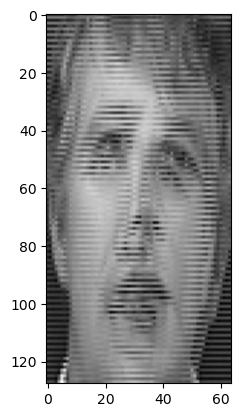

In [11]:
plt.imshow(x_train[0],cmap = 'gray')
print(x_train[0])

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

2022-12-07 14:33:07.506559: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 14:33:07.526975: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 62, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 12, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 21504)             0

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Funcka umożliwia zatrzymanie się uczenia 
#gdy wartość strat przstanie maleć
EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=3,
                          verbose=1)

history = model.fit(x_train, 
                    y_train, 
                    epochs=20, 
                    validation_data=(x_test, y_test),
                    callbacks = [EarlyStop]
                   )

Epoch 1/20
90/90 [==============================] - 39s 420ms/step - loss: 0.4728 - accuracy: 0.7774 - val_loss: 0.1705 - val_accuracy: 0.9264
Epoch 2/20
90/90 [==============================] - 35s 386ms/step - loss: 0.1449 - accuracy: 0.9406 - val_loss: 0.0961 - val_accuracy: 0.9542
Epoch 3/20
90/90 [==============================] - 33s 366ms/step - loss: 0.0447 - accuracy: 0.9847 - val_loss: 0.0096 - val_accuracy: 0.9958
Epoch 4/20
90/90 [==============================] - 34s 374ms/step - loss: 0.0081 - accuracy: 0.9983 - val_loss: 0.0053 - val_accuracy: 0.9986
Epoch 5/20
90/90 [==============================] - 32s 357ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 0.0046 - val_accuracy: 0.9972
Epoch 6/20
90/90 [==============================] - 32s 361ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 7/20
90/90 [==============================] - 32s 353ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.8632e-04 - val_accuracy: 1.

23/23 - 2s - loss: 2.1354e-04 - accuracy: 1.0000 - 2s/epoch - 97ms/step


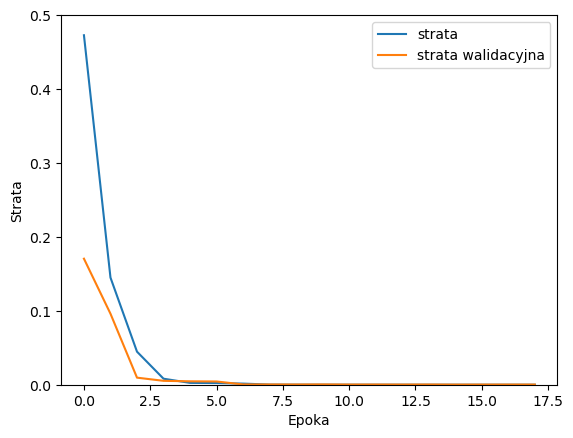

In [15]:
plt.plot(history.history['loss'], label='strata')
plt.plot(history.history['val_loss'], label = 'strata walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.ylim([0.0, 0.5])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

23/23 - 2s - loss: 2.1354e-04 - accuracy: 1.0000 - 2s/epoch - 105ms/step


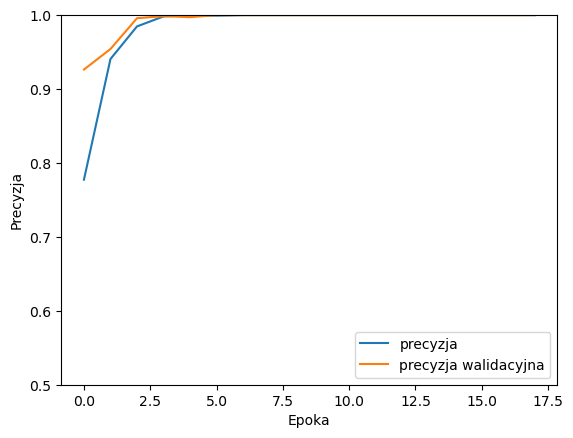

In [16]:
plt.plot(history.history['accuracy'], label='precyzja')
plt.plot(history.history['val_accuracy'], label = 'precyzja walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Precyzja')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [17]:
print(test_acc)

1.0


In [18]:
model.evaluate(x_test,  y_test, verbose=2)

23/23 - 2s - loss: 2.1354e-04 - accuracy: 1.0000 - 2s/epoch - 93ms/step


[0.00021353744312667308, 1.0]

In [19]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [20]:
arr = probability_model(x_test)

In [21]:
ok = 0
wrong = 0
err = 0

arr_2 = []

for x in range(len(arr)):
    
    maks = 0
    for i in range(10): 
        
        if arr[x][i] > arr[x][maks]:
              maks = i
                
    if maks == 0 :
        arr_2.append(0)
        
        if maks == y_test[x] :
            ok = ok + 1          
        else:
            wrong = wrong + 1
            
            
    if maks == 1 :
        arr_2.append(1)
        if maks == y_test[x] :
            ok = ok + 1        
        else:
            wrong = wrong + 1       
    
    
    if maks > 2 :
        err = err + 1
        print(x)


print(ok) 
print(wrong) 
print(err) 
     
     

720
0
0


In [22]:
names = [['Tn','Nn'],['Np', 'Tp']]
names = np.reshape(names,(2,2))
print(names)

tf.math.confusion_matrix(y_test,arr_2)

[['Tn' 'Nn']
 ['Np' 'Tp']]


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[365,   0],
       [  0, 355]], dtype=int32)>